In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

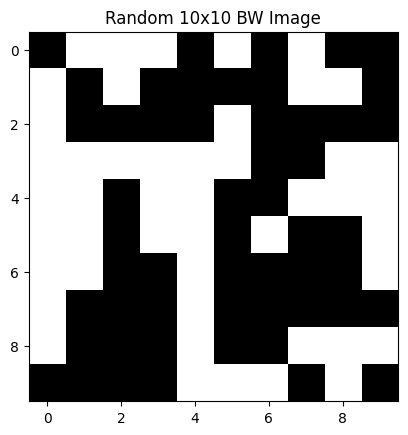

In [36]:
img = np.random.choice([0, 255], size=(10, 10), p=[0.5, 0.5]).astype(np.uint8)
plt.imshow(img, cmap='gray')
plt.title("Random 10x10 BW Image")
plt.show()

In [37]:
# Downsample using Average pooling
def ds_average(img, k=2):
    h, w = img.shape
    new_h = h // k
    new_w = w // k
    new_img = np.zeros((new_h, new_w), dtype=np.float32)

    for i in range(new_h):
        for j in range(new_w):
            block = img[i*k:(i+1)*k, j*k:(j+1)*k]
            new_img[i, j] = np.mean(block)

    return new_img.astype(np.uint8)


In [38]:
# Downsample using Max pooling
def ds_max(img, k=2):
    h, w = img.shape
    new_h = h // k
    new_w = w // k
    new_img = np.zeros((new_h, new_w), dtype=np.float32)

    for i in range(new_h):
        for j in range(new_w):
            block = img[i*k:(i+1)*k, j*k:(j+1)*k]
            new_img[i, j] = np.max(block)

    return new_img.astype(np.uint8)

In [39]:
# Downsample using Median pooling
def ds_median(img, k=2):
    h, w = img.shape
    new_h = h // k
    new_w = w // k
    new_img = [[0 for _ in range(new_w)] for _ in range(new_h)]

    for i in range(new_h):
        for j in range(new_w):
            vals = []
            for di in range(k):
                for dj in range(k):
                    vals.append(img[i*k + di, j*k + dj])

            new_img[i][j] = int(np.median(vals))

    return new_img

In [40]:
avg_img = np.array(ds_average(img, k=2), dtype=np.uint8)
max_img = np.array(ds_max(img, k=2), dtype=np.uint8)
median_img = np.array(ds_median(img, k=2), dtype=np.uint8)

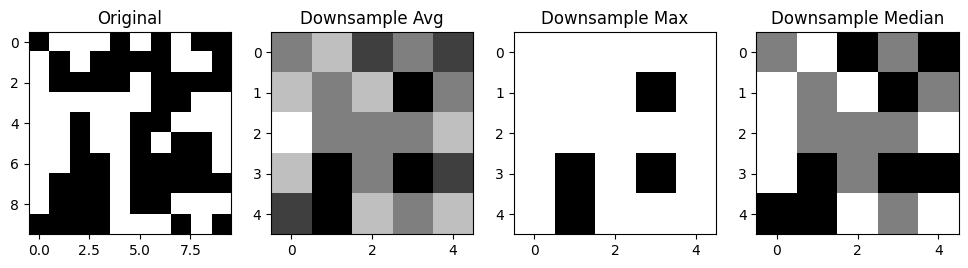

In [41]:
# Display results
plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(img, cmap="gray"); plt.title("Original")
plt.subplot(1,4,2); plt.imshow(avg_img, cmap="gray"); plt.title("Downsample Avg")
plt.subplot(1,4,3); plt.imshow(max_img, cmap="gray"); plt.title("Downsample Max")
plt.subplot(1,4,4); plt.imshow(median_img, cmap="gray"); plt.title("Downsample Median")
plt.show()

In [42]:
# Upsample Nearest Neighboor
def us_nn(img, k=2):
    h, w = img.shape
    new_h = k * h
    new_w = k * w

    # Create an empty NumPy array for the new image
    new_img = np.zeros((new_h, new_w), dtype=img.dtype)

    for i in range(new_h):
        for j in range(new_w):
            # Map new coordinates to old coordinates
            # This integer division effectively finds the nearest neighbor
            x_orig = i // k
            y_orig = j // k

            # Assign the pixel value from the nearest neighbor
            new_img[i, j] = img[x_orig, y_orig]

    return new_img.astype(np.uint8)

In [43]:
# Upsample Bilinear
def us_bilinear(img, k=2):
    h, w = img.shape
    new_h = int(k * h)
    new_w = int(k * w)
    new_img = np.zeros((new_h, new_w), dtype=np.float32)

    for i in range(new_h):
        for j in range(new_w):
            x = i / k
            y = j / k
            x1 = int(x)
            y1 = int(y)

            # Ensure indices don't go out of bounds
            x2 = min(x1 + 1, h - 1)
            y2 = min(y1 + 1, w - 1)

            # Get the four surrounding pixel values
            p1 = img[x1, y1]
            p2 = img[x1, y2]
            p3 = img[x2, y1]
            p4 = img[x2, y2]

            # Calculate interpolation weights
            dx = x - x1
            dy = y - y1

            # Perform bilinear interpolation
            interpolated_value = (1 - dx) * (1 - dy) * p1 + \
                                 (1 - dx) * dy * p2 + \
                                 dx * (1 - dy) * p3 + \
                                 dx * dy * p4

            new_img[i, j] = interpolated_value

    return new_img.astype(np.uint8)

In [44]:
import numpy as np

def us_bicubic(img, k=2):
    h, w = img.shape
    new_h = int(k * h)
    new_w = int(k * w)

    # Create an empty NumPy array for the new image with float32 data type
    new_img = np.zeros((new_h, new_w), dtype=np.float32)

    # Define the cubic convolution interpolation kernel
    def cubic_kernel(x):
        abs_x = np.abs(x)
        if abs_x <= 1:
            return (1.5 * abs_x - 2.5) * abs_x * abs_x + 1
        elif abs_x <= 2:
            return ((-0.5 * abs_x + 2.5) * abs_x - 4) * abs_x + 2
        else:
            return 0.0

    # Iterate over each pixel in the new image
    for i in range(new_h):
        for j in range(new_w):
            # Map new coordinates to old coordinates
            x_orig = i / k
            y_orig = j / k

            # Find the integer coordinates of the top-left pixel
            x_floor = int(np.floor(x_orig))
            y_floor = int(np.floor(y_orig))

            # Calculate fractional parts
            dx = x_orig - x_floor
            dy = y_orig - y_floor

            interpolated_value = 0

            # Iterate over the 4x4 neighborhood of pixels
            for m in range(-1, 3):
                for n in range(-1, 3):
                    # Get the coordinates of the neighbor pixel
                    neighbor_x = x_floor + m
                    neighbor_y = y_floor + n

                    # Check for boundary conditions
                    if 0 <= neighbor_x < h and 0 <= neighbor_y < w:
                        # Calculate weights using the cubic kernel
                        weight_x = cubic_kernel(dx - m)
                        weight_y = cubic_kernel(dy - n)

                        # Add the weighted pixel value to the total
                        interpolated_value += img[neighbor_x, neighbor_y] * weight_x * weight_y

            new_img[i, j] = interpolated_value

    # Clip values to the valid range [0, 255] and convert to uint8
    new_img = np.clip(new_img, 0, 255)
    return new_img.astype(np.uint8)

In [45]:
nn_img = us_nn(img, k=2)
bilinear_img = us_bilinear(img, k=2)
bicubic_img = us_bicubic(img, k=2)

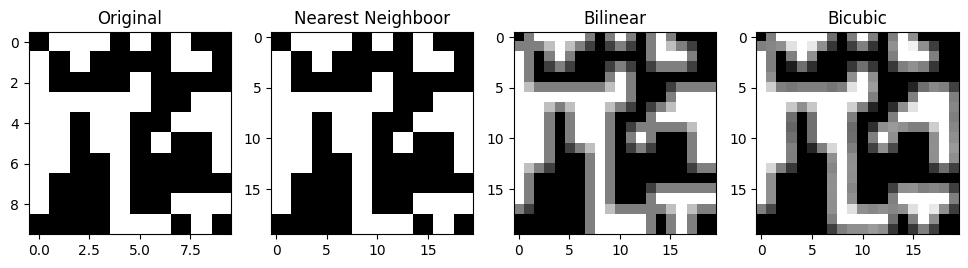

In [46]:
plt.figure(figsize=(12,5))
plt.subplot(1,4,1); plt.imshow(img, cmap="gray"); plt.title("Original")
plt.subplot(1,4,2); plt.imshow(nn_img, cmap="gray"); plt.title("Nearest Neighboor")
plt.subplot(1,4,3); plt.imshow(bilinear_img, cmap="gray"); plt.title("Bilinear")
plt.subplot(1,4,4); plt.imshow(bicubic_img, cmap="gray"); plt.title("Bicubic")
plt.show()